In [ ]:
# Names: Max Collins, Marwan Bit, Nikolas Hall
# Physics 24A
# Prof. Saeta
# Final Project: Gravity Assist "Slingshot" Maneuver

In [35]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from p24asolver import P24ASolver

# Constants we'll need:
JUPR = 10.0  # Radius of Jupiter's orbit
JUPω = 2.0   # Angular speed of Jupiter's orbit
JUPM = 10.0  # Mass of Jupiter
SUNM = 100.0 # Mass of the Sun
G = 6.67 * 10**(-8) # Gravitational constant
SATM = 1.0   # Mass of the satellite

    
# G = 6.67 * 10**(-8)   # Gravitational constant
fpsq = 4 * (np.pi)**2 # Four pi-squared

# Planets for a default simulation
SUN = Planet(m = 1.0, r = 0.5, ro = 0.0, c = "y")        # Figure out solar radius (AU) and Jupiter's mass (solar masses)
JUP = Planet(m = 0.005, r = 0.2, ro = 5.2, c = "g")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:


class Planet(P24ASolver):
    """Allows us to create objects that represent the Sun and the planets."""
    
    def __init__(self, **kwargs):
        """
        I'm going to use Python's keyword argument mechanism to handle the parameters.

        The kwargs parameter is a dictionary of all the named parameters and their values. We can use
        the built-in 'get' method to store parameter values, which allows us to provide default values
        in cases where no value was given.

        Note that we need to call the __init__ method of P24ASolver with a list of
        variable names. The first string in each variable tuple is the variable name, which you can use to
        refer to the variable, the second is a LaTeX representation that will look nice on a plot.
        """
        super().__init__(
            (('x1', '$x_1$'), ('v1', r'$\dot{x}_1$'),
             ('x2', '$x_2$'), ('v2', r'$\dot{x}_2$'))
        )
        # Now store variables, using defaults, if necessary
        self.mass = kwargs.get('m', 1.0)        # Mass, in solar masses
        self.radius = kwargs.get('r', 0.00047)  # Planetary radius, in AU (default is for Jupiter)
        self.rorbit = kwargs.get('ro', 1.0)     # Orbital radius, in AU (assumes perfectly circular orbits)
        self.period = np.sqrt(((self.rorbit)**3) / (self.mass + 1))     # Period of orbit determined by other parameters
                                                                        # Units are AU, years, and solar masses
        
        if self.period != 0:
            self.ω = (2 * np.pi) / self.period
        else:
            self.ω = 0
        
        self.color = kwargs.get('c', "b")   # Planet's color in the animation (blue by default)
    
    def __str__(self):
        "Produces a string representation of the planet's parameters."
        string = "Mass: " + str(self.mass) + "  Radius: " + str(self.radius) + "  Radius of Orbit: " + str(self.rorbit) + "  Period: " + str(self.period)
        return str(string)
        # Add units, and figure out how to get each attribute onto a new line.
    
    def orbit(self, R, ω, t):
        """
        Arguments: R is the radius of orbit of a planet, ω is its angular speed, and t is the time of interest.
        Returns: Cartesian coordinates for position of the planet at time t.
        """
        return (R * np.math.cos(ω * t), R * np.math.sin(ω * t))
    
    
class Satellite(P24ASolver):
    """Allows us to define an object representing our space probe. Simulates a solar system of planets with perfectly circular orbits."""
    
    def __init__(self, **kwargs):
        """
        I'm going to use Python's keyword argument mechanism to handle the parameters.

        The kwargs parameter is a dictionary of all the named parameters and their values. We can use
        the built-in 'get' method to store parameter values, which allows us to provide default values
        in cases where no value was given.

        Note that we need to call the __init__ method of P24ASolver with a list of
        variable names. The first string in each variable tuple is the variable name, which you can use to
        refer to the variable, the second is a LaTeX representation that will look nice on a plot.
        """
        super().__init__(
            (('x1', '$x_1$'), ('v1', r'$\dot{x}_1$'),
             ('x2', '$x_2$'), ('v2', r'$\dot{x}_2$'))
        )
        # Now store variables, using defaults, if necessary
        self.position = kwargs.get('r', (-1, 0))    # Satellite's position in Cartesian coordinates
                                                    # Default is x = -1 AU y = 0 AU
            
        self.velocity = kwargs.get('v', (0, 0))     # Satellite's velocity in the x- and y-directions
                                                    # Default is satellite at rest
        
        self.planets = kwargs.get('p', [SUN, JUP])  # A list of the planets that the satellite can interact with
                                                    # By default, includes the Sun and Jupiter

        self.shapes = []  # We'll add shapes for the satellite and planets later
        
        self.rtol = kwargs.get('rtol', 1e-10)  # Do we need these???
        self.atol = kwargs.get('atol', 1e-10)
        
        # We treat the satellite as though it has negligible mass and no radius
        # The satellite is a point moving through space
        
        
    def __str__(self):
        "Produces a string representation of a satellite."
        string = "Position: (x, y) = " + str(self.position) + "  Velocity: (vx, vy) = " + str(self.velocity)
        return str(string)
        
        
    def derivatives(self, t, Y):
        """ Accepts: Time of interest, derivatives vector, and """
        x1, v1, x2, v2 = Y  # Unpack the values
                            # x1 = x-position, v1 = x-velocity
                            # x2 = y-position, v2 = y-velocity
        
        
        θ = np.math.atan(x2 / x1) # Satellite's angular position
        # DO WE NEED THIS??
        # We don't use it anymore
        
        numPlanets = len(self.planets)
        
        Alist = []
        
        for planet in self.planets:          # For each planet in the simulation...
            
            xp1, xp2 = planet.orbit(planet.rorbit, planet.ω, t)    # Get the planet's cartesian position
            
            r_sq = (x1 - xp1)**2 + (x2 - xp2)**2   # Square of the satellite's distance from the current planet
            
            x = xp1 - x1
            y = xp2 - x2
            
            cosine_theta = y/np.sqrt(r_sq)
            
            sine_theta = x/np.sqrt(r_sq)

            
            # Get the components of the satellite's gravitational acceleration due to this planet
            a1 = float((fpsq * planet.mass) / r_sq) * cosine_theta #np.math.cos(θ)
            a2 = float((fpsq * planet.mass) / r_sq) * sine_theta #np.math.sin(θ)
            
            # Add those components to a list of accelerations
            Alist += [[a1, a2]]
            
        A1 = 0   # Total acceleration in the x-direction
        A2 = 0   # Total acceleration in the y-direction
        
        # Sum components to get the total x- and y-accelerations
        for a in Alist:
            A1 += a[0]
            A2 += a[1]
        
        return [v1, A1, v2, A2]   # Return a time derivative of Y
    
    
        
#         xj1, xj2 = self.orbit(JUPR, JUPω, t) # Jupiter's cartesian position
        
        
#         # Squares of satellite's distances from Sun and Jupiter
#         R_sun_sq = x1**2 + x2**2
#         R_jup_sq = (x1 - xj1)**2 + (x2 - xj2)**2
        
        
#         # Components of gravitational forces due to Sun (Fs) and Jupiter (Fj)
#         Fsx = float((G * SUNM * SATM) / R_sun_sq) * np.math.cos(θ)
#         Fsy = float((G * SUNM * SATM) / R_sun_sq) * np.math.sin(θ)
        
#         Fjx = float((G * JUPM * SATM) / R_sun_sq) * np.math.cos(JUPω * t)
#         Fjy = float((G * JUPM * SATM) / R_sun_sq) * np.math.sin(JUPω * t)
        
        
#         # Components of the net force
#         Fnetx = Fsx + Fjx
#         Fnety = Fsy + Fjy
        
        
#         # x and y components of satellite's acceleration
#         a1 = Fnetx / SATM  # x-acceleration
#         a2 = Fnety / SATM  # y-acceleration
        
#         return [v1, a1, v2, a2]



    def prepare_figure(self):
        """
        Function that creates the figure and axes for the animation.
        """

        fig, ax = plt.subplots(figsize = (10, 10))
        # We need to set the axes limits so each frame uses the same limits
        # I'll say that the center position of the first mass is at 2 and the second at 4
        ax.set_xlim((-6, 6))
        ax.set_ylim((-6, 6))
        
        self.shapes = [Circle((self.position), radius = 0.05, color = 'r')]
        
        for planet in self.planets:
            self.shapes.append(Circle((planet.rorbit, 0), radius = planet.radius, color = planet.color))
            
        #self.shapes = [Circle((x, 0), 1, 0.5, color='r')
        #              for x in (0, 20)]
        #self.shapes.append(Circle((0, 0), radius=0.1, color='y'))  # This is the Sun. Will probably delete this.
        
        # Figure out how to add unfilled circles representing the orbits.
        
        for s in self.shapes:
            ax.add_patch(s)
            
        return fig, ax

    
    def draw_frame(self, t):
        """
        Draw frame for time t
        """

        x1, v1, x2, v2 = self.solution.sol(t)
        
        x1 += self.position[0]
        x2 += self.position[1]
        
        # For patches, we first remove them
        # and then recreate them.
        numShapes = len(self.shapes)
        
        for n in (len(self.shapes), 0):
            self.shapes[n].remove()
            
        
        #for num in range(numShapes):
        #    self.shapes[numShapes - num - 1].remove()
        
        self.shapes = [Circle((x1, x2), radius = 0.05, color = 'r')]
        
#         self.shapes[2].remove()
#         self.shapes[1].remove()
#         self.carts[0].remove()
#         self.carts = []

#         for x in (x1, x2):
#             sat = Circle((x1, x2), radius = 0.05, color = 'r')
#             self._ax.add_patch(sat)
#             self.shapes.append(s)
        
        for planet in self.planets:
            p = Circle(planet.orbit(planet.rorbit, planet.ω, t), radius = planet.radius, color = planet.color)
            self.shapes.append(p)
        
        for s in self.shapes:
            self._ax.add_patch(s)
            
#             p = Rectangle((x, 0), 1, 0.5, color='r')
#             self._ax.add_patch(p)
#             self.carts.append(p)
#         c = Circle((x3, 0.25), radius=0.1, color='g')
#         self.carts.append(c)
#         self._ax.add_patch(c)

        # title = self._ax.set_title(f"t = {t:.2f}", usetex=False)

        # By returning the list of Artists that have changed,
        # we speed up the animation
        return self.shapes  # Might need to return a tuple (see P24A Solver)

<IPython.core.display.Javascript object>


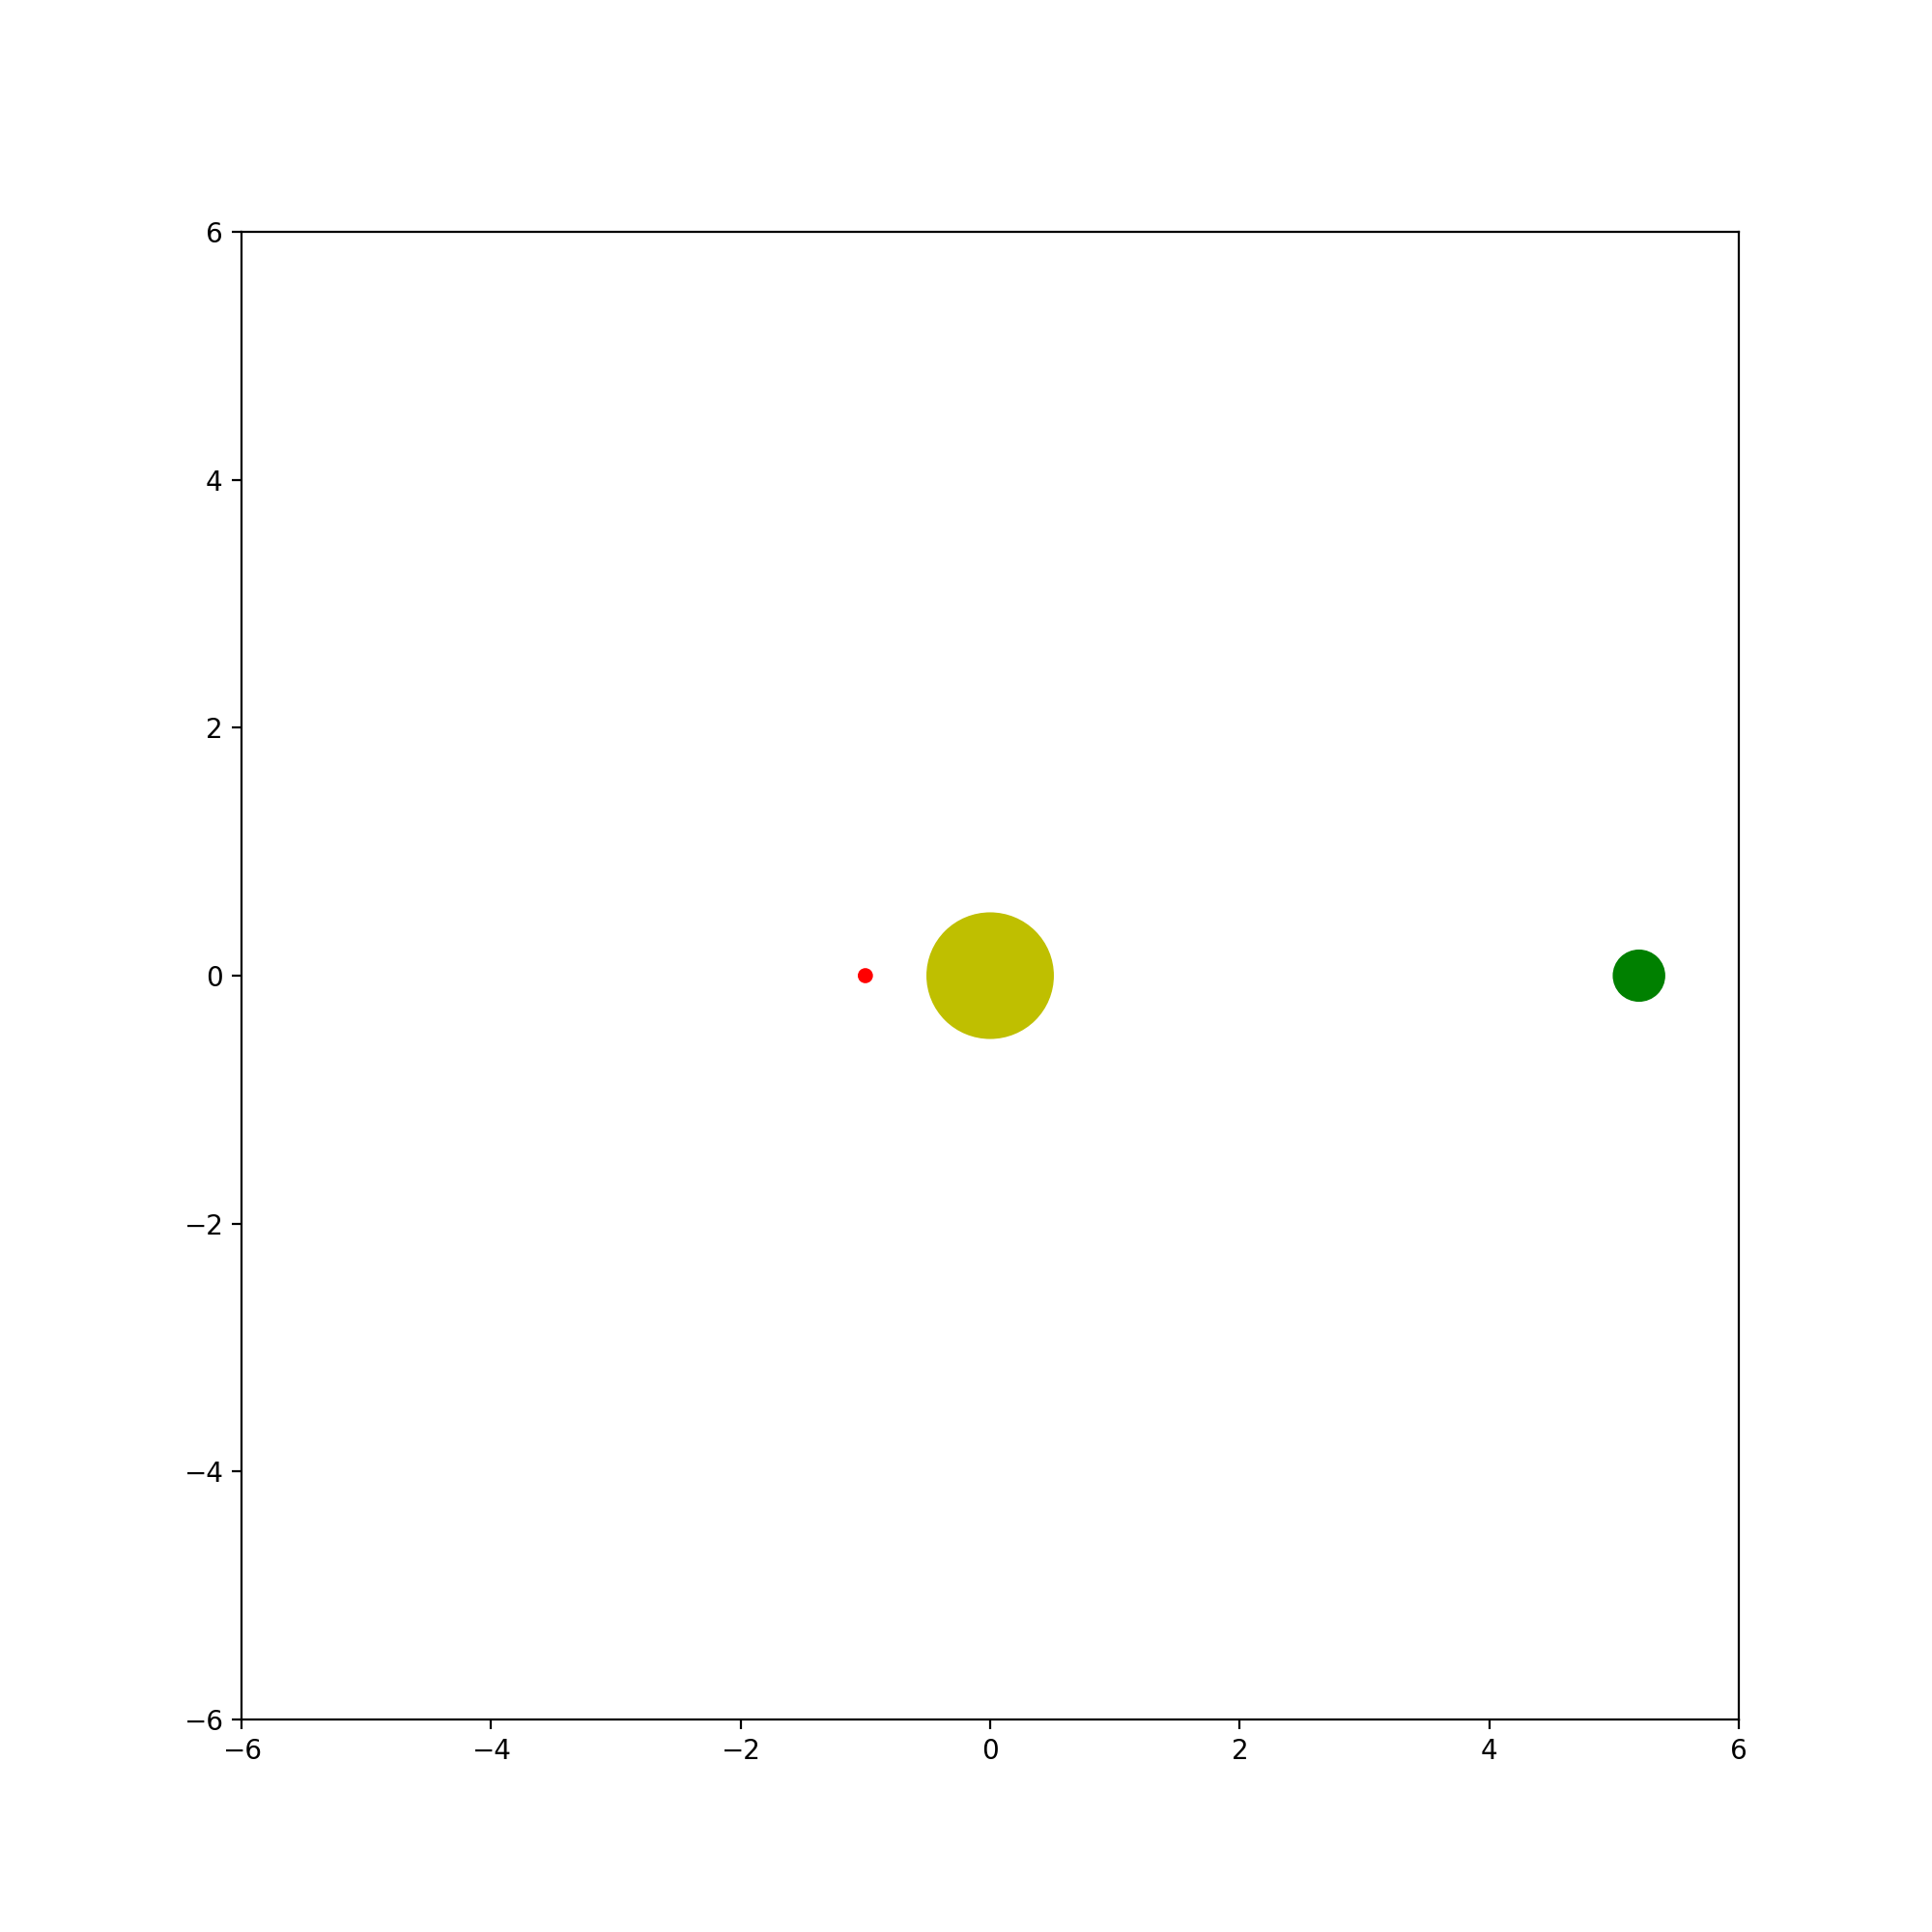

(<Figure size 1000x1000 with 1 Axes>, <AxesSubplot:>)

In [80]:
Earth = Planet()
str(Earth)
Sat = Satellite()
str(Sat)
Sat.prepare_figure()

<IPython.core.display.Javascript object>


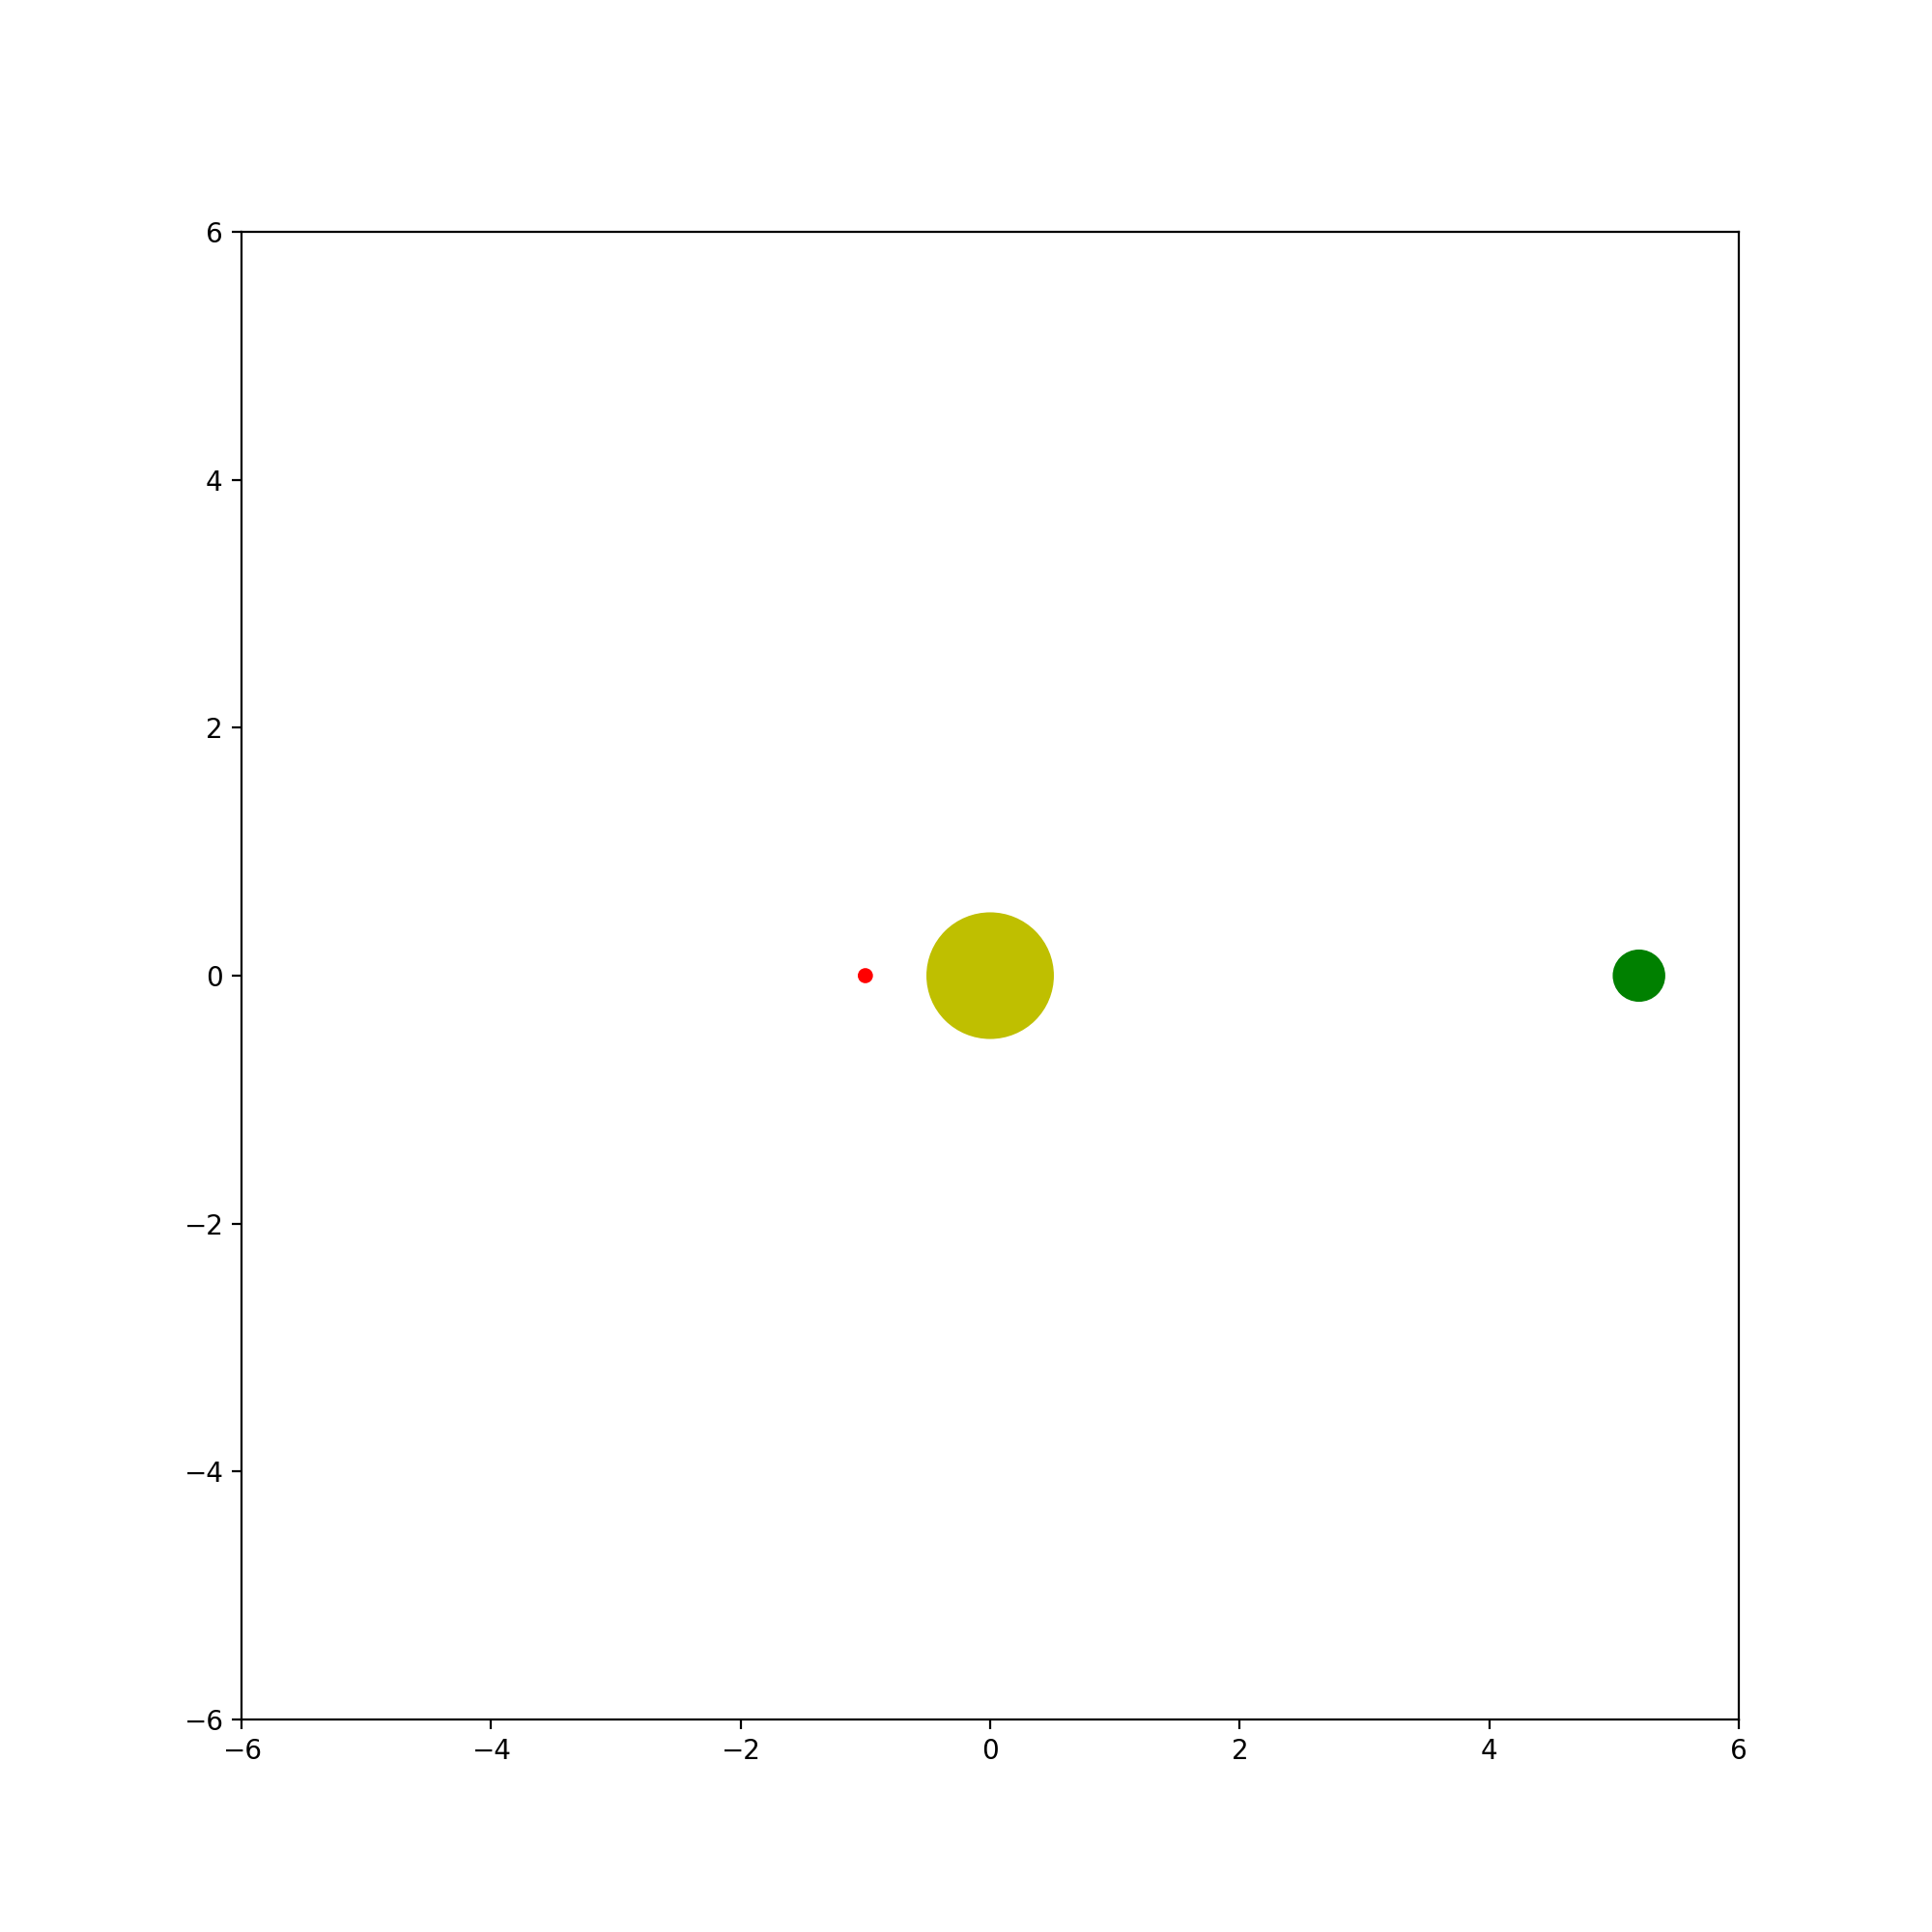

[<matplotlib.patches.Circle object at 0x7fc0fb19e580>, <matplotlib.patches.Circle object at 0x7fc112bd9a00>, <matplotlib.patches.Circle object at 0x7fc112bd9700>]
(0, 0)


In [50]:
plt.close('all')
sat = Satellite()
sat.solve((sat.position[0], sat.velocity[0], sat.position[1], sat.velocity[1]), (0, 100))
sat.animate(500);
print(sat.shapes)
print(sat.velocity)

# Maybe Jupiter's orbital period is too long?

<IPython.core.display.Javascript object>


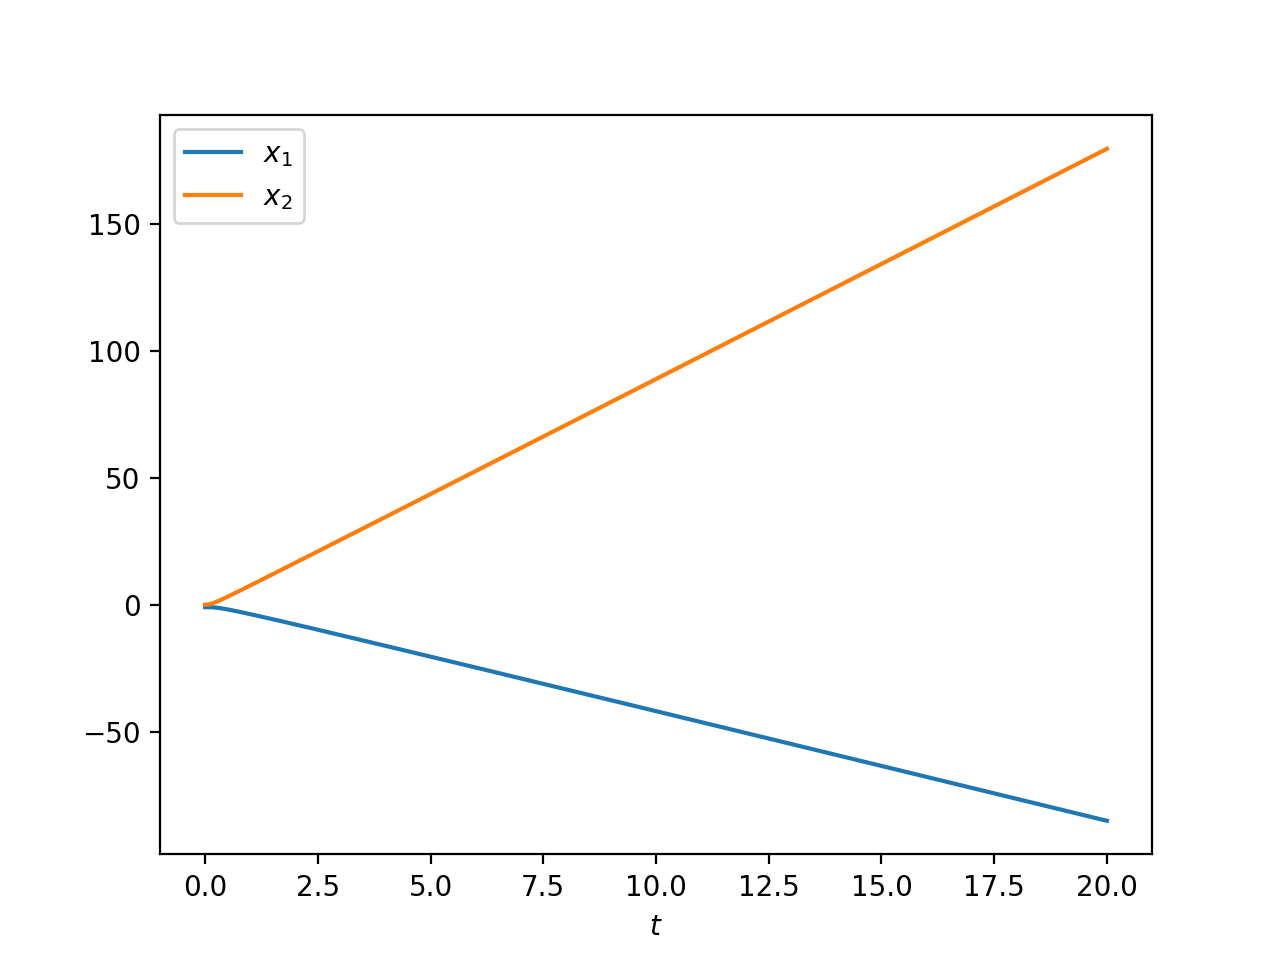

Mass: 1.0  Radius: 0.5  Radius of Orbit: 0.0  Period: 0.0; Mass: 0.005  Radius: 0.2  Radius of Orbit: 5.2  Period: 11.828290565903545
[]


In [51]:
times = np.linspace(0, 20, 401)
sat1 = Satellite(r = [-1, 0], v = [1, 1])
Yinitial = (sat1.position[0], sat.velocity[0], sat.position[1], sat.velocity[1])
sol1 = sat1.solve(Yinitial, (0, 200)).plot(times, ['x1', 'x2']);

print(str(sat1.planets[0]) + "; " + str(sat1.planets[1]))
print(sat1.shapes)

<IPython.core.display.Javascript object>


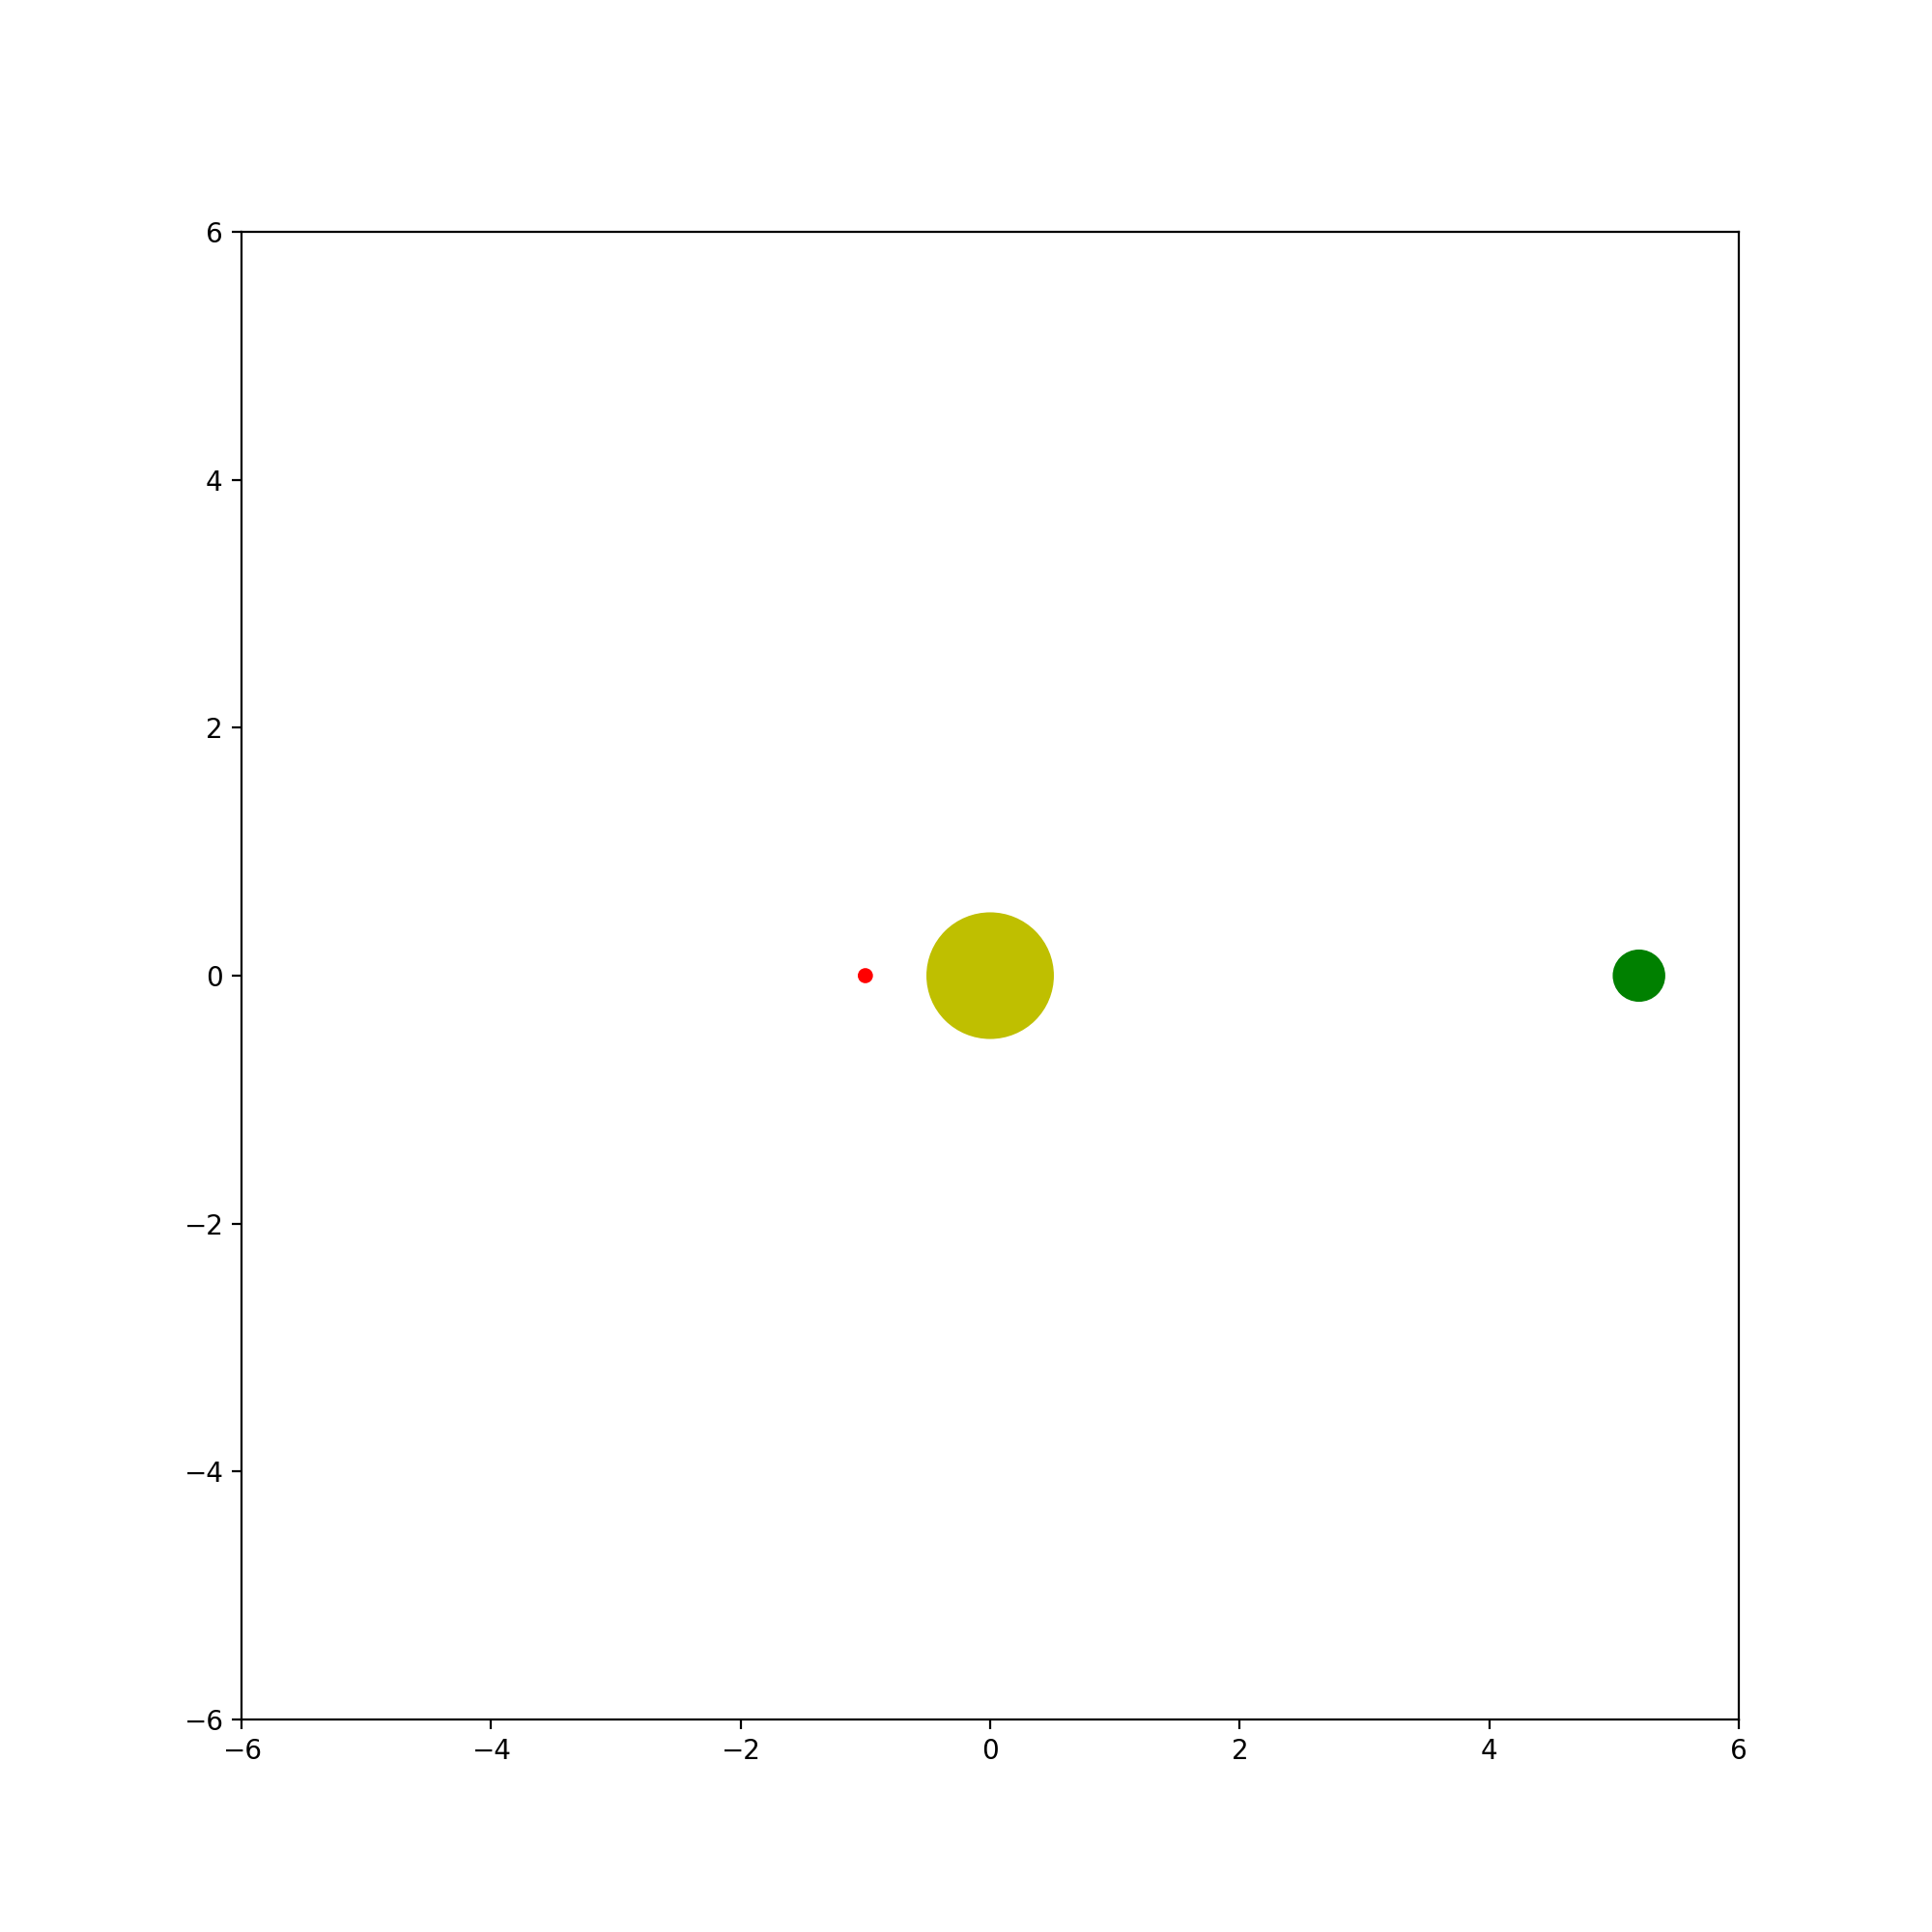

Mass: 1.0  Radius: 0.5  Radius of Orbit: 0.0  Period: 0.0; Mass: 0.005  Radius: 0.2  Radius of Orbit: 5.2  Period: 11.828290565903545
[<matplotlib.patches.Circle object at 0x7fc0f5ddd730>, <matplotlib.patches.Circle object at 0x7fc0f5dd7bb0>, <matplotlib.patches.Circle object at 0x7fc0f5dd7d30>]


In [52]:
sol1.animate(200);
print(str(sat1.planets[0]) + "; " + str(sat1.planets[1]))
print(sat1.shapes)